In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Co-ordinate Quantization

We need to take all the the time positions possible, and turn them into integers to be tokenized using quantization.


This is done simply by scaling the numbers knowing their max range and rounding them

In [2]:
import torch

In [6]:
max_seconds = 15
num_tokens = 256

original = torch.rand(1, 10000)*max_seconds
quantized = torch.round(original/max_seconds*num_tokens)
avg_error = torch.mean(torch.abs(original - quantized*max_seconds/num_tokens))
print(avg_error.item()*1000, "ms")

14.624467119574547 ms


# Checking this on real coordinates

~7.5ms error seems fairly reasonable for quantizing into 2048 tokens

Let's see how this looks

In [9]:
from nanodrz.data import gather_speakers_from_folder, artificial_diarisation_sample
from nanodrz import data
from nanodrz.utils import play, visualise_annotation

speakers = data.get_speakers()
len(speakers)

1742

7.928625


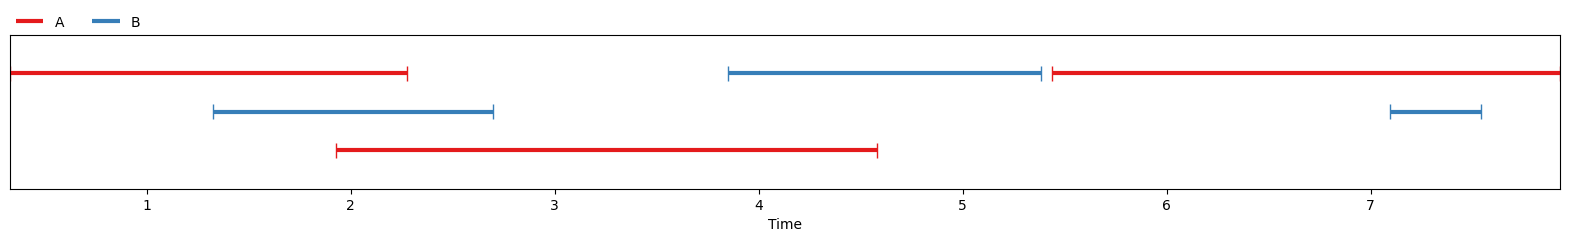

[0.3306970459301374, 2.278697045930137, 'A']
[1.3259475252006085, 2.6979475252006084, 'B']
[1.9269057580758817, 4.578905758075882, 'A']
[3.852255527765665, 5.3842555277656645, 'B']
[5.436644938243597, 7.928644938243597, 'A']
[7.095266175290453, 7.539266175290453, 'B']


In [10]:
audio, labels = data.artificial_diarisation_sample(speakers, max_secs=30, num_speakers=2,  interrupt_sec_mean=.2, interrupt_var=.5)
print(audio.shape[-1]/16000)
visualise_annotation(labels)
print("\n".join(str(l) for l in labels))
play(audio, 16000)

tensor([[  6.,  39.],
        [ 23.,  46.],
        [ 33.,  78.],
        [ 66.,  92.],
        [ 93., 135.],
        [121., 129.]])
12.005318887531757 ms
[[0.3306970459301374, 2.278697045930137, 'A'], [1.3259475252006085, 2.6979475252006084, 'B'], [1.9269057580758817, 4.578905758075882, 'A'], [3.852255527765665, 5.3842555277656645, 'B'], [5.436644938243597, 7.928644938243597, 'A'], [7.095266175290453, 7.539266175290453, 'B']]


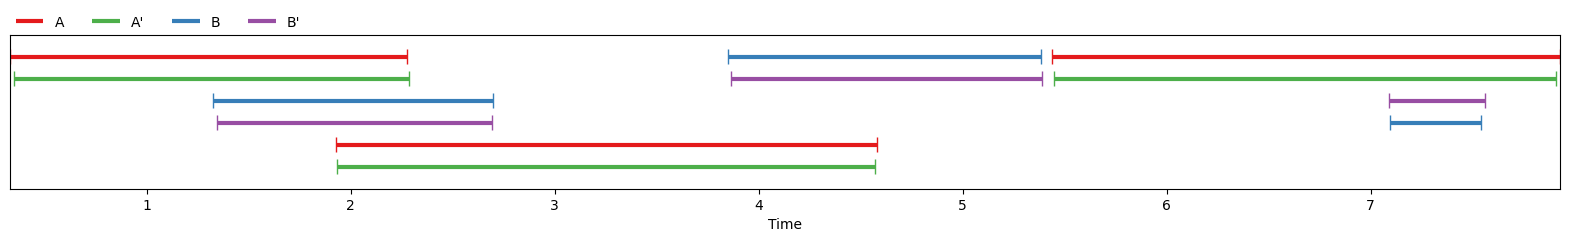

In [11]:
original = torch.tensor([[l[0], l[1]] for l in labels])
quantized = torch.round(original/max_seconds*num_tokens)
print(quantized)
unquantized =  quantized*max_seconds/num_tokens 
avg_error = torch.mean(torch.abs(original - unquantized))
print(avg_error.item()*1000, "ms")

# Visualise these labels

print(labels)
from copy import deepcopy

new_labels = deepcopy(labels)

for i, l in enumerate(new_labels):
    l[0] = unquantized[i][0]
    l[1] = unquantized[i][1]
    l[2] = l[2]+ "'"

# Let's see whether we can see a difference just for good measuer
visualise_annotation(labels+ new_labels)

# Desired Error Loop

Given a tolerable error e, what is the number of tokens we can get away with:

In [ ]:
max_seconds = 30
num_tokens = 556

# ms
e = 50

def compute_avg_error(num_tokens, max_seconds):
    original = torch.rand(1, 10000)*max_seconds
    quantized = torch.round(original/max_seconds*num_tokens)
    avg_error = torch.mean(torch.abs(original - quantized*max_seconds/num_tokens))
    avg_error = avg_error.item()*1000
    print(num_tokens, max_seconds, "secs", avg_error, "ms")
    return avg_error
    

avg_error = compute_avg_error(num_tokens, max_seconds)
while avg_error < e:
    num_tokens -= 16
    avg_error = compute_avg_error(num_tokens, max_seconds)